# 🚜 Sale Price of Bulldozer using ML for prediction

## 1. Problem definition

> Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

## 2. Data

The data is downloaded from the Kaggle blue book.
https://www.kaggle.com/c/bluebook-for-bulldozers/data

The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.


## 4. Features

The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine. A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
* saledate: the date of the sale

**Note:** Check the data dictionary.


In [102]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

In [87]:
# Import training and validation set and parsing date
df = pd.read_csv("./TrainAndValid.csv", low_memory = False, parse_dates = ["saledate"])
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA

In [88]:
# information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [89]:
# checking missing values
df.isna().sum()/len(df)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
saledate                    0.000000
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
T

In [90]:
# Let's check the column names
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [91]:
# summary statistics associated with quantitative variables 
df.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter
count,4.126980e+05,412698.000000,4.126980e+05,412698.000000,412698.000000,392562.000000,412698.000000,1.475040e+05
mean,2.011161e+06,31215.181414,1.230061e+06,6947.201828,135.169361,6.585268,1899.049637,3.522988e+03
std,1.080068e+06,23141.743695,4.539533e+05,6280.824982,9.646749,17.158409,292.190243,2.716993e+04
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000,0.000000e+00
25%,1.421898e+06,14500.000000,1.088593e+06,3261.000000,132.000000,1.000000,1985.000000,0.000000e+00
50%,1.645852e+06,24000.000000,1.284397e+06,4605.000000,132.000000,2.000000,1995.000000,0.000000e+00
75%,2.261012e+06,40000.000000,1.478079e+06,8899.000000,136.000000,4.000000,2001.000000,3.209000e+03
max,6.333349e+06,142000.000000,2.486330e+06,37198.000000,173.000000,99.000000,2014.000000,2.483300e+06


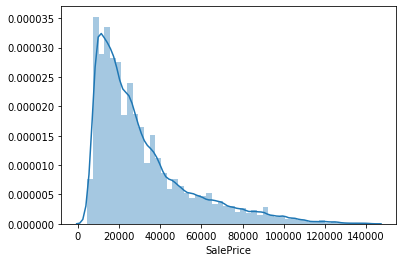

In [92]:
#df.SalePrice.plot(kind = "hist");
sns.distplot(df.SalePrice)
plt.show()

SalePrice is right skewed.

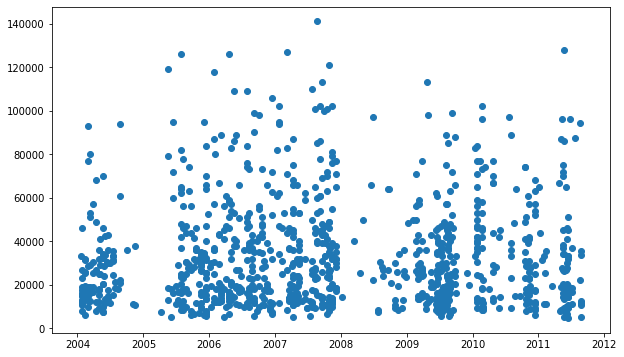

In [93]:
# scatter plot of SalePrice vs saledate
fig, ax = plt.subplots(figsize = (10, 6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000]);

In [94]:
# transpose the dataframe
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [95]:
# sort the dataframe by date
df.sort_values(by = ["saledate"], inplace = True, ascending = True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

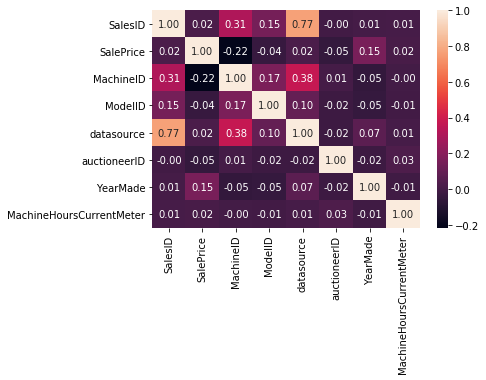

In [96]:
# correlation
sns.heatmap(df.corr(), annot = True, fmt = ".2f");

### Cleaning data

Before start modeling, there are some previous steps that have to be followed which include cleaning process, feature engineering  handling missing values, and so on.

In [97]:
def clean_data(df_tmp):
    """
    Performs transformatios on df and returns transform df
    
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - transformed df 
    """
    df_tmp["saleYear"] = df_tmp.saledate.dt.year
    df_tmp["saleMonth"] = df_tmp.saledate.dt.month
    df_tmp["saleDay"] = df_tmp.saledate.dt.day
    df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
    df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear
    
    df_tmp.drop("saledate", axis = 1, inplace = True)
    
    # Fill the numeric rows with the median
    for label, content in df_tmp.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df_tmp[label + "_is_missing"] = pd.isnull(content)
                df_tmp[label] = content.fillna(content.median())
    
    # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df_tmp[label + "_is_missing"] = pd.isnull(content)
            df_tmp[label] = pd.Categorical(content).codes + 1
    
    return df_tmp

In [98]:
# Clean train and valid data
train_df = clean_data(df)
train_df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [99]:
train_df.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now, the train_df dataframe is clean and ready to be use for modeling.

### Builiding and Evaluation Function

In [82]:
# creata evaluation function RMSLE (Root Mean Square Log Error)

def rmsle(y_test, y_preds):
    """
    Calculate RMSLE
    
    INPUT
    y_test - 
    y_preds - 
    
    OUTPUT
    score - 
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    score = {"Training MAE": mean_absolute_error(y_train, train_preds),
             "Validation MAE": mean_absolute_error(y_valid, val_preds),
             "Training RMSLE": rmsle(y_train, train_preds),
             "Validation RMSLE": rmsle(y_valid, val_preds),
             "Training R2": r2_score(y_train, train_preds),
             "Validation R2": r2_score(y_valid, val_preds)}
    return score

## Modeling

In [101]:
# split the data into validation and train datasets
df_val = train_df[train_df.saleYear == 2012]
df_train = train_df[train_df.saleYear != 2012]

# split data into X and Y
X_train, y_train = df_train.drop("SalePrice", axis = 1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis = 1), df_val.SalePrice

# Instantiate the model
model = RandomForestRegressor(n_jobs = -1, random_state = 42)

# fit the model
model.fit(X_train, y_train)

# scoring
show_scores(model)

{'Training MAE': 1578.2015208725463,
 'Validation MAE': 6120.959637950402,
 'Training RMSLE': 0.08426351714047395,
 'Validation RMSLE': 0.25557446689440955,
 'Training R2': 0.9875150955953674,
 'Validation R2': 0.8727175969771312}

### Hyperparameter tuning with RandomizedSearchCV

In [103]:
%%time

# Different RandomForestRegressor hyperparameter
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

# Instantiate
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state = 42),
                              param_distributions = rf_grid,
                              n_iter = 5,#change to 100
                              cv = 5,
                              verbose = True)

# Fit
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   46.2s finished


CPU times: user 39.3 s, sys: 2.4 s, total: 41.7 s
Wall time: 47.7 s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [104]:
# best params.
rs_model.best_params_

{'n_estimators': 10,
 'min_samples_split': 12,
 'min_samples_leaf': 17,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [105]:
# Evaluate
show_scores(rs_model)

{'Training MAE': 6839.695341531319,
 'Validation MAE': 8197.210217074162,
 'Training RMSLE': 0.3060882321326649,
 'Validation RMSLE': 0.3318578204761261,
 'Training R2': 0.7964915984093325,
 'Validation R2': 0.7821462870498238}

### Train a model with the best hyperparameters

**Note:** This were found after a 100 iterations of `RandomizedSearchCV`.


In [106]:
%%time

# the most ideal hyperparameters
ideal_model = RandomForestRegressor(n_jobs = -1,
                                    random_state = 42,
                                    n_estimators = 40,
                                    min_samples_leaf = 1,
                                    min_samples_split = 14,
                                    max_features = 0.5,
                                    max_samples = None)

ideal_model.fit(X_train, y_train)

CPU times: user 4min 59s, sys: 1.1 s, total: 5min
Wall time: 22 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [107]:
# Eval ideal_model
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Validation MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371855,
 'Validation RMSLE': 0.24524163989538328,
 'Training R2': 0.9588145522577225,
 'Validation R2': 0.8818019502450094}

## Predictions on the test data

In [108]:
df_test = pd.read_csv("./Test.csv", low_memory = False,parse_dates = ["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [109]:
# Clean test data
df_test = clean_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [110]:
# finding how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [111]:
# Manually adjust df_test to have 'auctioneerID_is_missing' column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [112]:
# Make predictions
test_preds = ideal_model.predict(df_test)

In [113]:
# Format predictions into Kaggle format
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test.SalesID
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [121]:
# Export Prediction data
df_preds.to_csv("./test_predictions.csv", index = False)